Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4566 - loss: 0.2083 - val_accuracy: 0.7139 - val_loss: 0.1004
Epoch 2/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7495 - loss: 0.0895 - val_accuracy: 0.8335 - val_loss: 0.0537
Epoch 3/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8779 - loss: 0.0426 - val_accuracy: 0.8959 - val_loss: 0.0339
Epoch 4/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9285 - loss: 0.0226 - val_accuracy: 0.9032 - val_loss: 0.0305
Epoch 5/5
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9524 - loss: 0.0140 - val_accuracy: 0.9120 - val_loss: 0.0345
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


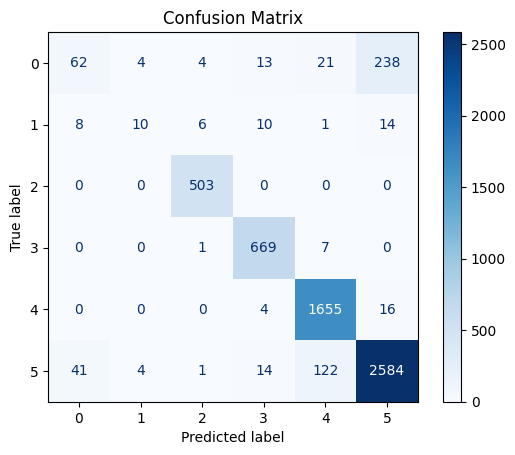


Accuracy: 0.9120
Precision (macro): 0.8092
Recall (macro): 0.7160

Classification Report:
              precision    recall  f1-score   support

           0     0.5586    0.1813    0.2737       342
           1     0.5556    0.2041    0.2985        49
           2     0.9767    1.0000    0.9882       503
           3     0.9423    0.9882    0.9647       677
           4     0.9164    0.9881    0.9509      1675
           5     0.9060    0.9342    0.9199      2766

    accuracy                         0.9120      6012
   macro avg     0.8092    0.7160    0.7326      6012
weighted avg     0.8963    0.9120    0.8975      6012



In [1]:
# Oversampling for class 2 and 3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")

columns_to_drop = [
    'recipe_number', 'recipe_code', 'recipe_name',
    'comment_id', 'user_id', 'user_name', 'created_at'
]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.dropna(subset=['text'])

texts = df_cleaned['text'].astype(str).values
labels = df_cleaned['stars'].values
numeric_features = df_cleaned[['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']]

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Oversampling sınıf 2, 3, 4
def oversample_class(class_label, factor):
    indices = np.where(labels == class_label)[0]
    text_part = np.repeat(text_padded[indices], factor, axis=0)
    num_part = np.repeat(numeric_features_scaled[indices], factor, axis=0)
    label_part = np.repeat(labels[indices], factor, axis=0)
    return text_part, num_part, label_part

t2, n2, l2 = oversample_class(2, 10)
t3, n3, l3 = oversample_class(3, 6)
t4, n4, l4 = oversample_class(4, 4)

X_text_all = np.concatenate([text_padded, t2, t3, t4], axis=0)
X_num_all = np.concatenate([numeric_features_scaled, n2, n3, n4], axis=0)
y_all = np.concatenate([labels, l2, l3, l4], axis=0)

X_text_all, X_num_all, y_all = shuffle(X_text_all, X_num_all, y_all, random_state=42)

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_all, X_num_all, y_all, test_size=0.2, random_state=42
)

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)(text_input)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

numeric_input = Input(shape=(X_num_train.shape[1],), name='numeric_input')
y = Dense(64, activation='relu')(numeric_input)

combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[text_input, numeric_input], outputs=z)

model.compile(
    optimizer=Adam(learning_rate=5e-4),  
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

history = model.fit(
    [X_text_train, X_num_train], y_train_cat,
    validation_data=([X_text_test, X_num_test], y_test_cat),
    epochs=5,
    batch_size=32
)

y_pred_probs = model.predict([X_text_test, X_num_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision (macro): {precision:.4f}")

recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall (macro): {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))